In [2]:
from deap import base
from deap import creator
from deap import tools
from deap.algorithms import varAnd

import gym_example

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

LENGTH_CHROM - длина хромосомы, подлежащей оптимизации (количество итераций)
POPULATION_SIZE - количество индивидуумов в популяции
P_CROSSOVER - вероятность скрещивания
P_MUTATION - вероятность мутации
MAX_GENERATIONS - максимальное количество поколений (итераций)
HALL_OF_FAME_SIZE - количество элитных особей

In [3]:
env = gym_example.make('MountainCar-v0', render_mode="rgb_array")
LENGTH_CHROM = 200 
POPULATION_SIZE = 50
P_CROSSOVER = 0.9
P_MUTATION = 0.2
MAX_GENERATIONS = 150
HALL_OF_FAME_SIZE = 3
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

AttributeError: module 'gym' has no attribute 'make'

In [38]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/home/dantedanger/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/dantedanger/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [39]:
toolbox = base.Toolbox()
toolbox.register("randomAction", random.randint, 0, 2)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.randomAction, LENGTH_CHROM)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

population = toolbox.populationCreator(n=POPULATION_SIZE)

In [40]:
def getCarScore(individual):
    FLAG_LOCATION = 0.5
    observation = env.reset()
    actionCounter = 0

    for action in individual:
        actionCounter += 1
        observation, reward, done, info, trash = env.step(action)

        if done:
            break

    if actionCounter < LENGTH_CHROM:
        score = 0 - (LENGTH_CHROM - actionCounter) / LENGTH_CHROM
    else:
        score = abs(observation[0] - FLAG_LOCATION)

    return score,

In [41]:
toolbox.register("evaluate", getCarScore)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=2, indpb=1.0/LENGTH_CHROM)

In [42]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [43]:
def eaSimpleElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__, callback=None):

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

        if callback:
            callback[0](*callback[1])

    return population, logbook


In [44]:
population, logbook = eaSimpleElitism(population, toolbox,
                                        cxpb=P_CROSSOVER,
                                        mutpb=P_MUTATION,
                                        ngen=MAX_GENERATIONS,
                                        halloffame=hof,
                                        stats=stats,
                                        verbose=True)

maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

best = hof.items[0]
print(best)

/home/dantedanger/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


gen	nevals	min     	avg    
0  	50    	0.685813	1.02475
1  	44    	0.685813	0.966208
2  	44    	0.685813	0.914024
3  	44    	0.663041	0.855096
4  	41    	0.638723	0.786441
5  	46    	0.592179	0.729028
6  	42    	0.58151 	0.699522
7  	44    	0.554938	0.676331
8  	38    	0.554938	0.666801
9  	43    	0.509015	0.646728
10 	45    	0.509015	0.629963
11 	42    	0.509015	0.621947
12 	45    	0.506895	0.599974
13 	44    	0.487836	0.581236
14 	44    	0.435673	0.565766
15 	44    	0.422488	0.536509
16 	44    	0.395608	0.524863
17 	40    	0.395608	0.513092
18 	46    	0.395608	0.504125
19 	45    	0.367984	0.472248
20 	45    	0.372223	0.458566
21 	44    	0.372223	0.462941
22 	44    	0.322381	0.442259
23 	46    	0.304909	0.433643
24 	42    	0.251281	0.422219
25 	42    	0.251281	0.406326
26 	45    	0.251281	0.404947
27 	44    	0.251281	0.393815
28 	42    	0.251281	0.383624
29 	45    	0.251281	0.391383
30 	39    	0.251281	0.382194
31 	37    	0.251281	0.371937
32 	37    	0.251281	0.34749 
33 	46    	0.234

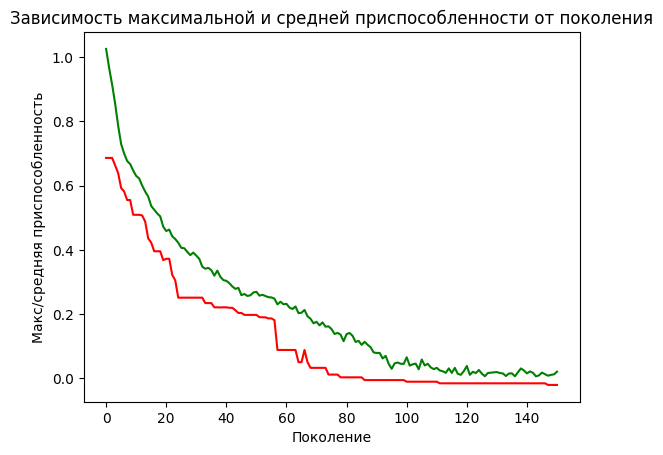

In [45]:
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
plt.show()

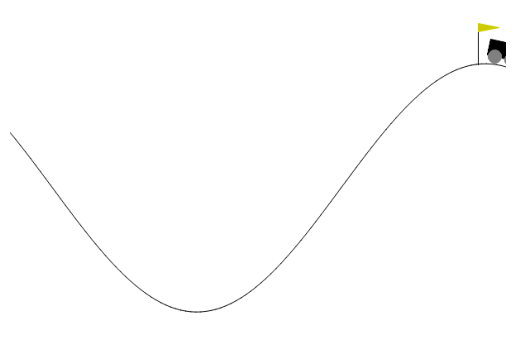

In [75]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
img_plot = ax.imshow(env.render())
plt.axis('off')
env.reset()
def update(frame):
    action = best[frame]
    env.step(action)
    img_plot.set_array(env.render())
    return img_plot,

num_frames = len(best)
animation = FuncAnimation(fig, update, frames=num_frames, blit=True)
HTML(animation.to_jshtml())